In [1]:
import os
import pickle

import numpy as np
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader import PuljaDataLoader
from models._dkt import UserModel
from models.utils import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 100

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_dkt"
            ),
            "model.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (X): Embedding(259, 20)
  (gru): GRU(40, 20, batch_first=True)
  (out_layer): Linear(in_features=20, out_features=259, bias=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
)

In [4]:
aucs_list = []
max_aucs = []

dir_list = ["01", "02", "03", "04", "05", "06", "07", "08"]

for i in dir_list:
    with open(
        os.path.join(
            os.path.join(
                ckpt_path,
                os.path.join("_dkt", i)
            ),
            "aucs.pkl"
        ),
        "rb"
    ) as f:
        aucs = pickle.load(f)
    
    max_auc = np.max(aucs)

    aucs_list.append(aucs)
    max_aucs.append(max_auc)

In [5]:
print("max_auc_mean: {}, max_auc_std: {}".format(np.mean(max_aucs), np.std(max_aucs)))

max_auc_mean: 0.8017582660019267, max_auc_std: 0.0013933174430204582


In [6]:
test_dataset[100]

(array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0

In [41]:
# 3등급 전처리: 0, 2, 3, 4, 5, 7, 8, 9, 10, 13, 19, 21, 100, 101
# 임의 전처리: 1, 2, 3, 4
# basis = 1.0: 0, 2, 4, 6, 7
# basis = 0.5: 0, 2, 3, 7
# discrete: 0, 2, 100
c_seq, d_seq, r_seq = test_dataset[2]

c_seq, cshft_seq, d_seq, dshft_seq, r_seq, rshft_seq = \
[c_seq[:-1]], [c_seq[1:]], [d_seq[:-1]], [d_seq[1:]], [r_seq[:-1]], [r_seq[1:]]

# r_seq = np.zeros_like(r_seq)
r_seq = np.ones_like(r_seq)

d_seq = np.ones_like(d_seq) * 0

###########################################
# alpha_seq, beta_seq, beta_shft_seq, gamma_seq, gamma_shft_seq, h_seq, C_seq = model(
#     LongTensor(c_seq),
#     LongTensor(cshft_seq),
#     LongTensor(d_seq),
#     LongTensor(dshft_seq),
#     FloatTensor(r_seq),
# )
###########################################
# alpha_seq, h_seq, C_seq = model(
#     LongTensor(c_seq),
#     LongTensor(d_seq),
#     FloatTensor(r_seq),
# )

# # c_one_hot_seq: [batch_size, seq_len, 1, num_c]
# c_one_hot_seq = one_hot(LongTensor(c_seq), model.num_c).float()
# c_one_hot_seq = torch.reshape(
#     c_one_hot_seq,
#     shape=[
#         -1,
#         c_one_hot_seq.shape[1],
#         c_one_hot_seq.shape[2]
#     ]
# ).unsqueeze(-2)
# beta_seq = torch.bmm(
#     torch.reshape(
#         c_one_hot_seq,
#         shape=[
#             -1,
#             c_one_hot_seq.shape[2],
#             c_one_hot_seq.shape[3]
#         ]
#     ),
#     torch.reshape(
#         C_seq, shape=[-1, C_seq.shape[2], C_seq.shape[3]]
#     )
# )
# beta_seq = torch.reshape(
#     beta_seq, shape=[1, seq_len]
# )

# gamma_seq = model.D1(LongTensor(d_seq)).squeeze()
###########################################
alpha_seq, h_seq = model(
    LongTensor(c_seq),
    LongTensor(d_seq),
    FloatTensor(r_seq),
)
alpha_seq = alpha_seq.squeeze()

C_seq = alpha_seq.mean(-1)
alpha_seq = C_seq.mean(-1)
###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()

# sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta_seq).detach().cpu().numpy()[0]

# sigmoid_alpha_beta_gamma_seq = torch.sigmoid(alpha_seq + beta_seq - gamma_seq).detach().cpu().numpy()[0]

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

CQ_seq = torch.sigmoid(C_seq.squeeze() + alpha_seq.unsqueeze(-1)).detach().cpu().numpy()
C_seq = C_seq.squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

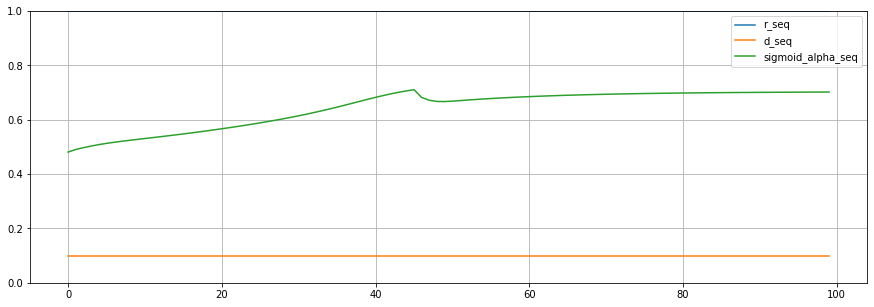

In [42]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
# plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_alpha_beta_seq")
# plt.plot(sigmoid_alpha_beta_gamma_seq, label="sigmoid_alpha_beta_gamma_seq")
# plt.plot(r_seq_ma, label="r_seq_ma")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

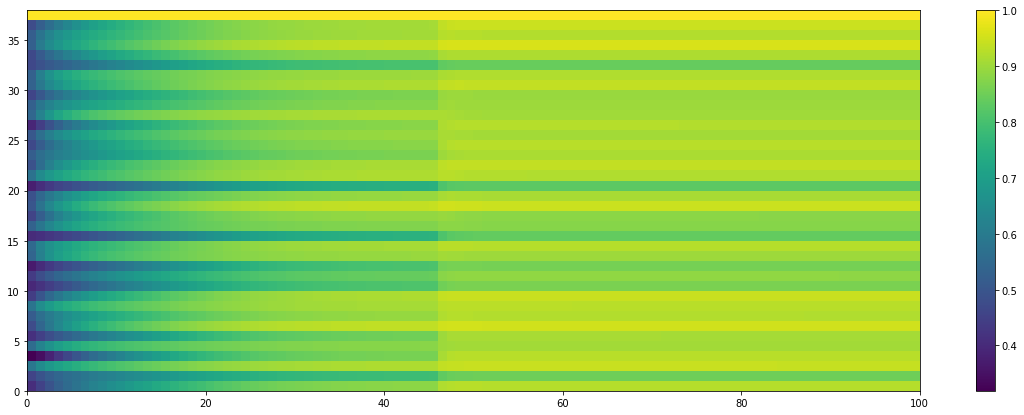

In [40]:
plt.figure(figsize=[20, 7], facecolor="white")
temp = np.concatenate([CQ_seq.T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [34]:
CQ_seq[0], CQ_seq[-1], c_seq, d_seq

(array([0.1825023 , 0.175031  , 0.2286346 , 0.13687246, 0.2928865 ,
        0.15750766, 0.14216408, 0.2628691 , 0.2573806 , 0.14054294,
        0.14001065, 0.18129489, 0.17150985, 0.335623  , 0.21989265,
        0.17896205, 0.3402212 , 0.22179125, 0.23378232, 0.2548177 ,
        0.15718715, 0.23604338, 0.20540015, 0.1987645 , 0.19900705,
        0.2626487 , 0.19086862, 0.32534042, 0.19671315, 0.15854119,
        0.15980071, 0.23002483, 0.22890706, 0.15678193, 0.2001126 ,
        0.2073643 , 0.1937468 ], dtype=float32),
 array([0.03317556, 0.06731194, 0.0316131 , 0.01553759, 0.06721847,
        0.02381434, 0.01233418, 0.03102453, 0.03892997, 0.01242752,
        0.02160409, 0.03677185, 0.02962442, 0.06243796, 0.02375035,
        0.05451826, 0.07815977, 0.02016162, 0.02291652, 0.02542602,
        0.03465934, 0.0235789 , 0.02884787, 0.03696952, 0.02984326,
        0.0393066 , 0.02062715, 0.0513758 , 0.03228909, 0.02834718,
        0.01989085, 0.04282549, 0.04009248, 0.01924093, 0.01546083,